In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

Georgia
-------
Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx). The following counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release: Cobb, DeKalb, Gwinnett. Forsyth and Fulton use shapefiles sourced from the respective counties.

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election:

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary
Bartow: Split Cassville/Hamilton Crossing
Candler: Merge Candler/Metter as Jack Strickland Comm Center
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5 
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits 
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps
Towns: Merge Macedonia/Tate City

Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

G20PRERTRU - Donald J. Trump (Republican Party)
G20PREDBID - Joseph R. Biden (Democratic Party)
G20PRELJOR - Jo Jorgensen (Libertarian Party)

C20PRERTRU - Donald J. Trump (Republican Party)
C20PREDBID - Joseph R. Biden (Democratic Party)
C20PRELJOR - Jo Jorgensen (Libertarian Party)

G20USSRPER - David A. Perdue (Republican Party)
G20USSDOSS - Jon Ossoff (Democratic Party)
G20USSLHAZ - Shane Hazel (Libertarian Party)

S20USSRLOE - Kelly Loeffler (Republican Party)
S20USSRCOL - Doug Collins (Republican Party)
S20USSRGRA - Derrick E. Grayson (Republican Party)
S20USSRJAC - Annette Davis Jackson (Republican Party)
S20USSRTAY - Kandiss Taylor (Republican Party)
S20USSRJOH - A. Wayne Johnson (Republican Party)
S20USSDWAR - Raphael Warnock (Democratic Party)
S20USSDJAC - Deborah Jackson (Democratic Party)
S20USSDLIE - Matt Lieberman (Democratic Party)
S20USSDJOH - Tamara Johnson-Shealey (Democratic Party)
S20USSDJAM - Jamesia James (Democratic Party)
S20USSDSLA - Joy Felicia Slade (Democratic Party)
S20USSDWIN - Richard Dien Winfield (Democratic Party)
S20USSDTAR - Ed Tarver (Democratic Party)
S20USSLSLO - Brian Slowinski (Libertarian Party)
S20USSGFOR - John Fortuin (Green Party)
S20USSIBUC - Allen Buckley (Independent)
S20USSIBAR - Al Bartell (Independent)
S20USSISTO - Valencia Stovall (Independent)
S20USSIGRE - Michael Todd Greene (Independent)

G20PSCRSHA - Jason Shaw (Republican Party)
G20PSCDBRY - Robert G. Bryant (Democratic Party)
G20PSCLMEL - Elizabeth Melton (Libertarian Party)

G20PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)
G20PSCDBLA - Daniel Blackman (Democratic Party)
G20PSCLWIL - Nathan Wilson (Libertarian Party)


In [2]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        #county = county_area.attrib.get('text')
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
                        #print(x)
                    #print("")
                #print("")
            #print("")
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general = pd.DataFrame(z,columns=dfcols)
print(df_general)

       county                                            contest  \
0       Crisp                     President of the United States   
1       Crisp                     President of the United States   
2       Crisp                     President of the United States   
3       Crisp                     President of the United States   
4       Crisp                     President of the United States   
...       ...                                                ...   
581519  Evans  Claxton Sunday Package Sales Referendum - Special   
581520  Evans  Claxton Sunday Package Sales Referendum - Special   
581521  Evans  Claxton Sunday Package Sales Referendum - Special   
581522  Evans  Claxton Sunday Package Sales Referendum - Special   
581523  Evans  Claxton Sunday Package Sales Referendum - Special   

                           choice           voting_method  \
0       Donald J. Trump (I) (Rep)      Election Day Votes   
1       Donald J. Trump (I) (Rep)      Election Day Votes   


In [3]:
loaded_counties = os.listdir("./raw-from-source/Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        #county = county_area.attrib.get('text')
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_recount = pd.DataFrame(z,columns=dfcols)

In [4]:
print(df_recount)
print(df_recount["contest"].unique())

       county                         contest                     choice  \
0      Oconee  President of the United States  Donald J. Trump (I) (Rep)   
1      Oconee  President of the United States  Donald J. Trump (I) (Rep)   
2      Oconee  President of the United States  Donald J. Trump (I) (Rep)   
3      Oconee  President of the United States  Donald J. Trump (I) (Rep)   
4      Oconee  President of the United States  Donald J. Trump (I) (Rep)   
...       ...                             ...                        ...   
31867  Thomas  President of the United States         Jo Jorgensen (Lib)   
31868  Thomas  President of the United States         Jo Jorgensen (Lib)   
31869  Thomas  President of the United States         Jo Jorgensen (Lib)   
31870  Thomas  President of the United States         Jo Jorgensen (Lib)   
31871  Thomas  President of the United States         Jo Jorgensen (Lib)   

            voting_method         precinct num_votes  
0      Election Day Votes       

In [5]:
contest_changes_dict = {'President of the United States':'President-Recount',
 'President of the United States/Presidentede los Estados Unidos':'President-Recount'}

df_recount["contest"] = df_recount["contest"].map(contest_changes_dict).fillna(df_recount["contest"])

In [6]:
print(df_general.shape)
print(df_recount.shape)

ga_election = pd.concat([df_general,df_recount])
print(len(ga_election["county"].unique()))

(581524, 6)
(31872, 6)
159


In [7]:
office_list = ['President of the United States','US Senate (Perdue)','US Senate (Loeffler) - Special',
              'Public Service Commission District 1','Public Service Commission District 4',
              'US Senate (Loeffler) - Special Election','President-Recount','President of the United States/Presidentede los Estados Unidos',
              'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1',
       'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4','US Senate (Perdue)/Senado de los EE.UU. (Perdue)',
       'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial',]

ga_election = ga_election[ga_election["contest"].isin(office_list)]

In [8]:
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4'
 'US Senate (Loeffler) - Special Election'
 'President of the United States/Presidentede los Estados Unidos'
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)'
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial'
 'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1'
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4'
 'President-Recount']


In [9]:
contest_changes_dict = {'US Senate (Loeffler) - Special Election':'US Senate (Loeffler) - Special',
                        'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial':'US Senate (Loeffler) - Special',
                        'US Senate (Perdue)/Senado de los EE.UU. (Perdue)':'US Senate (Perdue)',
                        'President of the United States/Presidentede los Estados Unidos':'President of the United States',
                        'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1':'Public Service Commission District 1',
                        'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4':'Public Service Commission District 4'}

ga_election["contest"] = ga_election["contest"].map(contest_changes_dict).fillna(ga_election["contest"])
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4' 'President-Recount']


In [10]:
ga_election["num_votes"]=ga_election["num_votes"].astype(int)
sum(ga_election["num_votes"])

29581664

In [11]:
print(ga_election["choice"].unique())

['Donald J. Trump (I) (Rep)' 'Joseph R. Biden (Dem)' 'Jo Jorgensen (Lib)'
 'David A. Perdue (I) (Rep)' 'Jon Ossoff (Dem)' 'Shane Hazel (Lib)'
 'Al Bartell (Ind)' 'Allen Buckley (Ind)' 'Doug Collins (Rep)'
 'John Fortuin (Grn)' 'Derrick E. Grayson (Rep)'
 'Michael Todd Greene (Ind)' 'Annette Davis Jackson (Rep)'
 'Deborah Jackson (Dem)' 'Jamesia James (Dem)' 'A. Wayne Johnson (Rep)'
 'Tamara Johnson-Shealey (Dem)' 'Matt Lieberman (Dem)'
 'Kelly Loeffler (I) (Rep)' 'Joy Felicia Slade (Dem)'
 'Brian Slowinski (Lib)' 'Valencia Stovall (Ind)' 'Ed Tarver (Dem)'
 'Kandiss Taylor (Rep)' 'Raphael Warnock (Dem)'
 'Richard Dien Winfield (Dem)' 'Jason Shaw (I) (Rep)'
 'Robert G. Bryant (Dem)' 'Elizabeth Melton (Lib)'
 'Lauren Bubba McDonald, Jr. (I) (Rep)' 'Daniel Blackman (Dem)'
 'Nathan Wilson (Lib)' 'Matt Lierberman (Dem)']


In [12]:
cand_change_dict = {'Matt Lierberman (Dem)':'Matt Lieberman (Dem)'}
ga_election["choice"] = ga_election["choice"].map(cand_change_dict).fillna(ga_election["choice"])

In [13]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))

In [14]:
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]
ga_election["choice"]=ga_election["choice"]+ga_election["contest"]
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

In [15]:
column_changes_dict = {'A. Wayne Johnson (Rep)US Senate (Loeffler) - Special':'S20USSRJOH',
       'Al Bartell (Ind)US Senate (Loeffler) - Special':'S20USSIBAR',
       'Allen Buckley (Ind)US Senate (Loeffler) - Special':'S20USSIBUC',
       'Annette Davis Jackson (Rep)US Senate (Loeffler) - Special':'S20USSRJAC',
       'Brian Slowinski (Lib)US Senate (Loeffler) - Special':'S20USSLSLO',
       'Daniel Blackman (Dem)Public Service Commission District 4':'G20PSCDBLA',
       'David A. Perdue (I) (Rep)US Senate (Perdue)':'G20USSRPER',
       'Deborah Jackson (Dem)US Senate (Loeffler) - Special':'S20USSDJAC',
       'Derrick E. Grayson (Rep)US Senate (Loeffler) - Special':'S20USSRGRA',
       'Donald J. Trump (I) (Rep)President of the United States':'G20PRERTRU',
       'Donald J. Trump (I) (Rep)President-Recount':'C20PRERTRU',
       'Doug Collins (Rep)US Senate (Loeffler) - Special':'S20USSRCOL',
       'Ed Tarver (Dem)US Senate (Loeffler) - Special':'S20USSDTAR',
       'Elizabeth Melton (Lib)Public Service Commission District 1':'G20PSCLMEL',
       'Jamesia James (Dem)US Senate (Loeffler) - Special':'S20USSDJAM',
       'Jason Shaw (I) (Rep)Public Service Commission District 1':'G20PSCRSHA',
       'Jo Jorgensen (Lib)President of the United States':'G20PRELJOR',
       'Jo Jorgensen (Lib)President-Recount':'C20PRELJOR',
       'John Fortuin (Grn)US Senate (Loeffler) - Special':'S20USSGFOR',
       'Jon Ossoff (Dem)US Senate (Perdue)':'G20USSDOSS',
       'Joseph R. Biden (Dem)President of the United States':'G20PREDBID',
       'Joseph R. Biden (Dem)President-Recount':'C20PREDBID',
       'Joy Felicia Slade (Dem)US Senate (Loeffler) - Special':'S20USSDSLA',
       'Kandiss Taylor (Rep)US Senate (Loeffler) - Special':'S20USSRTAY',
       'Kelly Loeffler (I) (Rep)US Senate (Loeffler) - Special':'S20USSRLOE',
       'Lauren Bubba McDonald, Jr. (I) (Rep)Public Service Commission District 4':'G20PSCRMCD',
       'Matt Lieberman (Dem)US Senate (Loeffler) - Special':'S20USSDLIE',
       'Michael Todd Greene (Ind)US Senate (Loeffler) - Special':'S20USSIGRE',
       'Nathan Wilson (Lib)Public Service Commission District 4':'G20PSCLWIL',
       'Raphael Warnock (Dem)US Senate (Loeffler) - Special':'S20USSDWAR',
       'Richard Dien Winfield (Dem)US Senate (Loeffler) - Special':'S20USSDWIN',
       'Robert G. Bryant (Dem)Public Service Commission District 1':'G20PSCDBRY',
       'Shane Hazel (Lib)US Senate (Perdue)':'G20USSLHAZ',
       'Tamara Johnson-Shealey (Dem)US Senate (Loeffler) - Special':'S20USSDJOH',
       'Valencia Stovall (Ind)US Senate (Loeffler) - Special':'S20USSISTO'}

In [16]:
ga_election = ga_election.rename(columns=column_changes_dict)

In [17]:
print(ga_election.columns)

Index(['unique_ID', 'county', 'county_fips', 'precinct', 'S20USSRJOH',
       'S20USSIBAR', 'S20USSIBUC', 'S20USSRJAC', 'S20USSLSLO', 'G20PSCDBLA',
       'G20USSRPER', 'S20USSDJAC', 'S20USSRGRA', 'G20PRERTRU', 'C20PRERTRU',
       'S20USSRCOL', 'S20USSDTAR', 'G20PSCLMEL', 'S20USSDJAM', 'G20PSCRSHA',
       'G20PRELJOR', 'C20PRELJOR', 'S20USSGFOR', 'G20USSDOSS', 'G20PREDBID',
       'C20PREDBID', 'S20USSDSLA', 'S20USSRTAY', 'S20USSRLOE', 'G20PSCRMCD',
       'S20USSDLIE', 'S20USSIGRE', 'G20PSCLWIL', 'S20USSDWAR', 'S20USSDWIN',
       'G20PSCDBRY', 'G20USSLHAZ', 'S20USSDJOH', 'S20USSISTO'],
      dtype='object', name='choice')


In [18]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/ga_2020/ga_2020.shp")

In [19]:
print(vest_ga_20.shape)

(2679, 44)


In [20]:
ga_election['FIPS2'] = ga_election["county_fips"]

In [21]:
data_columns = ['G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL']


for race in data_columns:
    if (sum(vest_ga_20[race])-sum(ga_election[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_ga_20[race])-sum(ga_election[race]))+" votes")
        print("\tVEST: "+str(sum(vest_ga_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
    else:
        print(race+":EQUAL")

G20PRERTRU:EQUAL
G20PREDBID:EQUAL
G20PRELJOR:EQUAL
C20PRERTRU:EQUAL
C20PREDBID:EQUAL
C20PRELJOR:EQUAL
G20USSRPER:EQUAL
G20USSDOSS:EQUAL
G20USSLHAZ:EQUAL
S20USSRLOE:EQUAL
S20USSRCOL:EQUAL
S20USSRGRA:EQUAL
S20USSRJAC:EQUAL
S20USSRTAY:EQUAL
S20USSRJOH:EQUAL
S20USSDWAR:EQUAL
S20USSDJAC:EQUAL
S20USSDLIE:EQUAL
S20USSDJOH:EQUAL
S20USSDJAM:EQUAL
S20USSDSLA:EQUAL
S20USSDWIN:EQUAL
S20USSDTAR:EQUAL
S20USSLSLO:EQUAL
S20USSGFOR:EQUAL
S20USSIBUC:EQUAL
S20USSIBAR:EQUAL
S20USSISTO:EQUAL
S20USSIGRE:EQUAL
G20PSCRSHA:EQUAL
G20PSCDBRY:EQUAL
G20PSCLMEL:EQUAL
G20PSCRMCD:EQUAL
G20PSCDBLA:EQUAL
G20PSCLWIL:EQUAL


In [22]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_ga_20.groupby(["FIPS2"]).sum()[i]-ga_election.groupby(["FIPS2"]).sum()[i]
    print(diff)
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313    0
315    0
317    0
319    0
321    0
Name: G20PRERTRU, Length: 159, dtype: int64
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313    0
315    0
317    0
319    0
321    0
Name: G20PREDBID, Length: 159, dtype: int64
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313    0
315    0
317    0
319    0
321    0
Name: G20PRELJOR, Length: 159, dtype: int64
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313    0
315    0
317    0
319    0
321    0
Name: C20PRERTRU, Length: 159, dtype: int64
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313    0
315    0
317    0
319    0
321    0
Name: C20PREDBID, Length: 159, dtype: int64
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313    0
315    0
317    0
319    0
321    0
Name: C20PRELJOR, Length: 159, dtype: int64
FIPS2
001    0
003    0
005    0
007    0
009    0
      ..
313  

In [23]:
for i in list(vest_ga_20['FIPS2'].unique()):
    if i not in (list(ga_election['FIPS2'].unique())):
        print(i)

print(vest_ga_20[vest_ga_20['FIPS2'].isna()])

None
       DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
1329   051XFTPU     None       None       None    None      None       None   
1447  029FTSTEW     None       None       None    None      None       None   
2125  215FTBEN2     None       None       None    None      None       None   
2128  215FTBEN4     None       None       None    None      None       None   
2146  215FTBEN3     None       None       None    None      None       None   
2229  215ZZZZZZ     None       None       None    None      None       None   
2230  215FTBEN1     None       None       None    None      None       None   

     FIPS2  G20PRERTRU  G20PREDBID  ...  S20USSIBAR  S20USSISTO  S20USSIGRE  \
1329  None           0           0  ...           0           0           0   
1447  None           0           0  ...           0           0           0   
2125  None           0           0  ...           0           0           0   
2128  None           0           0  ...       

In [24]:
print(vest_ga_20)

      DISTRICT  CTYSOSID PRECINCT_I          PRECINCT_N   CTYNAME CTYNUMBER  \
0       215122    215122        122       FIRST AFRICAN  MUSCOGEE       106   
1       215108    215108        108  ST MARK/HEIFERHORN  MUSCOGEE       106   
2       057031    057031        031           R T JONES  CHEROKEE        28   
3       057033    057033        033             SALACOA  CHEROKEE        28   
4        01506     01506         06              CENTER    BARTOW         8   
...        ...       ...        ...                 ...       ...       ...   
2674  121SC14A  121SC14A      SC14A               SC14A    FULTON        60   
2675    12109B    12109B        09B                 09B    FULTON        60   
2676   121CH05   121CH05       CH05                CH05    FULTON        60   
2677  121FA01D  121FA01D      FA01D               FA01D    FULTON        60   
2678     07707     07707         07        FISCHER ROAD    COWETA        38   

     CTYNUMBER2 FIPS2  G20PRERTRU  G20PREDBID  ... 

In [25]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_I"]

join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

right_only    2067
left_only     2044
both           612
Name: _merge, dtype: int64


In [26]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

both          2545
right_only     134
left_only      111
Name: _merge, dtype: int64


In [27]:
left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

left_only.to_csv("./source_only.csv")
right_only.to_csv("./VEST_only.csv")

In [28]:
example_csv = pd.read_csv("./source_vest_id_changes.csv")
example_fips_dict = dict(zip(example_csv["source_ID"],example_csv["vest_ID"]))

In [29]:
ga_election["unique_ID"] = ga_election["unique_ID"].map(example_fips_dict).fillna(ga_election["unique_ID"])

In [57]:
join_attempt_2 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both = join_attempt_1[join_attempt_1["_merge"]=="both"]
left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

both          2658
right_only      23
left_only        0
Name: _merge, dtype: int64


In [58]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)
    
validater_row(both,data_columns)


There are  2545  total rows
0  of these rows have election result differences
2545  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


In [31]:
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race+"_y"]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


## Shapefiles 

In [62]:
shapefiles_state = gp.read_file("./raw-from-source/Shapefiles/vtd2020-shape-4-20-21/VTD2020-Shape.shp")

In [69]:
vest_ga_20[vest_ga_20["FIPS2"]=="089"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
661,0517-03C,0517-03C,7-03C,PB EDWARDS GYM,CHATHAM,25,025,051,510,244,...,5,1,493,228,28,488,226,27,"POLYGON ((-81.14533 32.12428, -81.14561 32.124...",051-PB EDWARDS GYM
662,0517-07C,0517-07C,7-07C,ROTHWELL BAPTIST CHURCH,CHATHAM,25,025,051,1581,1036,...,8,9,1564,926,90,1541,944,83,"POLYGON ((-81.23330 32.11055, -81.23375 32.110...",051-ROTHWELL BAPTIST CHURCH
666,0517-04C,0517-04C,7-04C,LAKE SHORE COMM CTR,CHATHAM,25,025,051,441,1464,...,9,4,423,1391,96,420,1404,71,"POLYGON ((-81.15813 32.15219, -81.15835 32.152...",051-LAKE SHORE COMM CTR
667,0517-06C,0517-06C,7-06C,POOLER CITY HALL,CHATHAM,25,025,051,1030,1087,...,10,6,1007,1023,78,986,1031,67,"POLYGON ((-81.27262 32.12394, -81.27209 32.123...",051-POOLER CITY HALL
791,0517-05C,0517-05C,7-05C,WOODLAWN BAPTIST CHURCH,CHATHAM,25,025,051,311,433,...,2,0,302,412,25,296,416,16,"POLYGON ((-81.17403 32.11970, -81.17394 32.119...",051-WOODLAWN BAPTIST CHURCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,0511-16C,0511-16C,1-16C,FERGUSON AVE BAPTIST,CHATHAM,25,025,051,1497,589,...,6,3,1505,501,67,1482,514,55,"POLYGON ((-81.11000 31.96878, -81.10920 31.968...",051-FERGUSON AVE BAPTIST
2396,0514-12C,0514-12C,4-12C,ST PETERS EPISCOPAL,CHATHAM,25,025,051,1353,618,...,0,1,1429,472,51,1409,483,41,"POLYGON ((-81.01946 31.99354, -81.01924 31.993...",051-ST PETERS EPISCOPAL
2408,0512-02C,0512-02C,2-02C,BLACKSHEAR COMMUNITY CENTER,CHATHAM,25,025,051,161,713,...,4,3,166,652,38,170,646,32,"POLYGON ((-81.08825 32.07329, -81.08810 32.073...",051-BLACKSHEAR COMMUNITY CENTER
2409,0511-12C,0511-12C,1-12C,ISLE OF HOPE BAPTIST,CHATHAM,25,025,051,1080,544,...,3,1,1162,403,40,1140,409,34,"POLYGON ((-81.05529 31.97908, -81.05635 31.979...",051-ISLE OF HOPE BAPTIST


In [68]:
shapefiles_state[shapefiles_state["FIPS2"]=="051"]

,ID,AREA,DATA,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CNTY,FIPS2,CTYNAME,...,UKNMALEREG,UKNMALEVOT,UNKMALEVOT,UKNFMREG20,UKNFMVOTED,UKNFMVOTE1,UKNOWNREG2,UKNOWNVOTE,UKNOWVOTED,geometry
1217,88577,7.914923,276,0514-06C,0514-06C,4-06C,FIRST BAPTIST CHURCH OF THE ISLAND,025,051,CHATHAM,...,74.0,51.0,68.919998,74.0,44.0,59.459999,1.0,0.0,0.00,"POLYGON ((-80.96682 32.02390, -80.96647 32.024..."
1218,88578,1.587025,275,0514-05C,0514-05C,4-05C,SAINT FRANCIS EPISCOPAL CHURCH,025,051,CHATHAM,...,67.0,33.0,49.250000,103.0,60.0,58.250000,2.0,0.0,0.00,"POLYGON ((-80.95972 32.03496, -80.95883 32.035..."
1220,88580,5.824897,273,0514-02C,0514-02C,4-02C,FRANK MURRAY COMMUNITY CENTER,025,051,CHATHAM,...,111.0,56.0,50.450001,104.0,57.0,54.810001,1.0,0.0,0.00,"POLYGON ((-81.02876 32.06165, -81.02948 32.062..."
1221,88581,1.173903,280,0514-11C,0514-11C,4-11C,TYBEE IS SCH CAFE,025,051,CHATHAM,...,64.0,38.0,59.380001,57.0,33.0,57.889999,2.0,1.0,50.00,"POLYGON ((-80.84589 32.01384, -80.84572 32.013..."
1222,88833,1.337283,270,0513-13C,0513-13C,3-13C,NEW COV 7 DAY ADV CH,025,051,CHATHAM,...,100.0,33.0,33.000000,93.0,45.0,48.389999,9.0,1.0,11.11,"POLYGON ((-81.07582 31.98913, -81.07618 31.989..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,96769,0.248060,324,0518-09C,0518-09C,8-09C,MOSES JACKSON CENTER,025,051,CHATHAM,...,53.0,13.0,24.530001,55.0,19.0,34.549999,1.0,0.0,0.00,"POLYGON ((-81.11225 32.08174, -81.11231 32.081..."
1342,96770,1.277383,317,0518-01C,0518-01C,8-01C,CIVIC CENTER,025,051,CHATHAM,...,44.0,11.0,25.000000,53.0,12.0,22.639999,2.0,0.0,0.00,"POLYGON ((-81.09268 32.07531, -81.09325 32.075..."
1343,96771,0.307020,259,0512-12C,0512-12C,2-12C,WILLIAMS COURT APTS,025,051,CHATHAM,...,119.0,36.0,30.250000,90.0,32.0,35.560001,2.0,1.0,50.00,"POLYGON ((-81.10136 32.05246, -81.10151 32.052..."
1344,96772,0.308145,318,0518-02C,0518-02C,8-02C,HELLENIC CENTER,025,051,CHATHAM,...,98.0,37.0,37.759998,92.0,37.0,40.220001,4.0,3.0,75.00,"POLYGON ((-81.09833 32.06513, -81.09722 32.064..."


In [33]:
#Filter out Cobb, Gwinnett, and DeKalb

In [34]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties
fips_codes = ["13135","13067","13089"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Shapefiles/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

<AxesSubplot:>

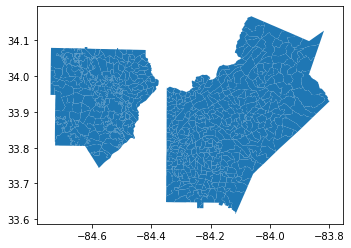

In [35]:
shapefiles_census.plot()

In [36]:
shapefiles_fulton = gp.read_file("./raw-from-source/Shapefiles/Fulton/Voting_Precincts/Voting_Precincts.shp")

In [37]:
shapefiles_forsyth  = gp.read_file("./raw-from-source/Shapefiles/Forsyth/Voting_Precinct-shp/Voting_Precinct.shp")

In [38]:
print(shapefiles_census.head())

  STATEFP COUNTYFP   VTDST      NAMELSAD VTDI LSAD CHNG_TYPE ORIG_NAME  \
0      13      135  000001     HARBINS A    A   00      None      None   
1      13      135  000002  ROCKBRIDGE A    A   00      None      None   
2      13      135  000003        DACULA    A   00      None      None   
3      13      135  000004     SUWANEE A    A   00      None      None   
4      13      135  000028  ROCKYCREEK A    A   00      None      None   

  ORIG_CODE RELATE          NAME VINTAGE FUNCSTAT JUSTIFY  MTFCC  \
0      None   None     HARBINS A      90        N    None  G5240   
1      None   None  ROCKBRIDGE A      90        N    None  G5240   
2      None   None        DACULA      90        N    None  G5240   
3      None   None     SUWANEE A      90        N    None  G5240   
4      None   None  ROCKYCREEK A      90        N    None  G5240   

                                            geometry  
0  POLYGON Z ((-83.92720 33.95932 0.00000, -83.92...  
1  POLYGON Z ((-84.07069 33.80553 0.

In [39]:
print(shapefiles_state.columns)

Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CNTY', 'FIPS2', 'CTYNAME',
       ...
       'UKNMALEREG', 'UKNMALEVOT', 'UNKMALEVOT', 'UKNFMREG20', 'UKNFMVOTED',
       'UKNFMVOTE1', 'UKNOWNREG2', 'UKNOWNVOTE', 'UKNOWVOTED', 'geometry'],
      dtype='object', length=116)


In [40]:
#Cobb, Gwinnett and DeKalb
"13135","13067","13089"

#Fulton and Forsyth
"13121","13117"

filter_list = ["135","067","089","121","117"]

shapefiles_state = shapefiles_state[~shapefiles_state["FIPS2"].isin(filter_list)]

epsg:4019


<AxesSubplot:>

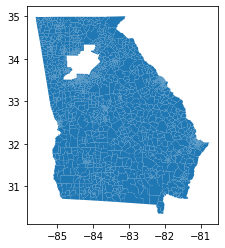

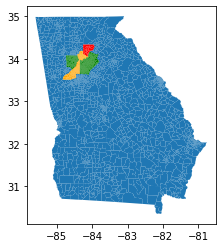

In [41]:
print(vest_ga_20.crs)

shapefiles_forsyth = shapefiles_forsyth.to_crs(4019)
shapefiles_fulton = shapefiles_fulton.to_crs(4019)
shapefiles_census = shapefiles_census.to_crs(4019)

shapefiles_state.plot()

ax = shapefiles_state.plot()
shapefiles_forsyth.plot(ax = ax,color="red")
shapefiles_fulton.plot(ax = ax,color="orange")
shapefiles_census.plot(ax = ax,color="green")

In [42]:
print(shapefiles_state.columns)
print(shapefiles_forsyth.columns)
print(shapefiles_fulton.columns)
print(shapefiles_census.columns)

Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CNTY', 'FIPS2', 'CTYNAME',
       ...
       'UKNMALEREG', 'UKNMALEVOT', 'UNKMALEVOT', 'UKNFMREG20', 'UKNFMVOTED',
       'UKNFMVOTE1', 'UKNOWNREG2', 'UKNOWNVOTE', 'UKNOWVOTED', 'geometry'],
      dtype='object', length=116)
Index(['OBJECTID', 'PRECINCTID', 'NAME', 'COUNTY', 'Shape__Are', 'Shape__Len',
       'geometry'],
      dtype='object')
Index(['OBJECTID', 'ProposalNo', 'Status', 'RetireStat', 'VoterDist',
       'TurnOut', 'ActVoters', 'FeatureID', 'FacilityID', 'PrecinctN',
       'ShapeSTAre', 'ShapeSTLen', 'geometry'],
      dtype='object')
Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'geometry'],
      dtype='object')


In [43]:
print(shapefiles_state.head())

   ID      AREA  DATA DISTRICT CTYSOSID PRECINCT_I            PRECINCT_N CNTY  \
0   1  3.383541   687   073131   073131        131  JOURNEY COMM. CHURCH  036   
1   2  1.636596   667   073064   073064        064  GRACE BAPTIST CHURCH  036   
2   3  5.598643   664   073061   073061        061       GREENBRIER HIGH  036   
3   4  0.872412   666   073063   073063        063      RIVERVIEW CHURCH  036   
4   5  2.609909   688   073132   073132        132      WESLEY METHODIST  036   

  FIPS2   CTYNAME  ...  UKNMALEREG  UKNMALEVOT  UNKMALEVOT  UKNFMREG20  \
0   073  COLUMBIA  ...        40.0        25.0   62.500000        42.0   
1   073  COLUMBIA  ...       167.0        86.0   51.500000       162.0   
2   073  COLUMBIA  ...       158.0        92.0   58.230000       169.0   
3   073  COLUMBIA  ...        43.0        33.0   76.739998        47.0   
4   073  COLUMBIA  ...        94.0        59.0   62.770000       112.0   

   UKNFMVOTED  UKNFMVOTE1  UKNOWNREG2  UKNOWNVOTE  UKNOWVOTED  \
0  

In [44]:
shapefiles_state = shapefiles_state[['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CNTY','CTYNAME','FIPS2','geometry']]
shapefiles_forsyth = shapefiles_forsyth[["PRECINCTID","NAME","COUNTY","geometry"]]
shapefiles_fulton = shapefiles_fulton[["OBJECTID","VoterDist","geometry"]]
shapefiles_census = shapefiles_census[["STATEFP","COUNTYFP","VTDST","NAMELSAD","NAME","geometry"]]

In [45]:
print(vest_ga_20.columns)

shapefile_col_list = ['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME','CTYNUMBER2', 'FIPS2','geometry']

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'geometry', 'unique_ID'],
      dtype='object')


In [46]:
shapefiles_state.loc[:,"CTYNUMBER2"] = shapefiles_state.loc[:,"CNTY"]

shapefiles_state = shapefiles_state[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [47]:
print(shapefiles_forsyth.head())

shapefiles_forsyth.loc[:,"DISTRICT"] = "117"+ shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"CTYSOSID"] = shapefiles_forsyth.loc[:,"DISTRICT"]
shapefiles_forsyth.loc[:,"PRECINCT_I"] = shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"PRECINCT_N"] = shapefiles_forsyth.loc[:,"PRECINCTID"] + " " + shapefiles_forsyth.loc[:,"NAME"]
shapefiles_forsyth.loc[:,"CTYNAME"] = "FORSYTH"
shapefiles_forsyth.loc[:,"CTYNUMBER2"] = "058"
shapefiles_forsyth.loc[:,"FIPS2"] = "117"

shapefiles_forsyth = shapefiles_forsyth[shapefile_col_list]

  PRECINCTID           NAME   COUNTY  \
0         27        CONCORD  Forsyth   
1         06     CROSSROADS  Forsyth   
2         04      CHESTATEE  Forsyth   
3         03  BROWNS BRIDGE  Forsyth   
4         05  COAL MOUNTAIN  Forsyth   

                                            geometry  
0  POLYGON ((-84.16395 34.29828, -84.16402 34.298...  
1  POLYGON ((-83.97539 34.30389, -83.97550 34.303...  
2  POLYGON ((-83.94688 34.30902, -83.94620 34.308...  
3  POLYGON ((-84.09370 34.25201, -84.09327 34.252...  
4  POLYGON ((-84.07448 34.29508, -84.07471 34.292...  


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [48]:
shapefiles_fulton.head()

shapefiles_fulton.loc[:,"DISTRICT"] = "121"+ shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYSOSID"] = shapefiles_fulton.loc[:,"DISTRICT"]
shapefiles_fulton.loc[:,"PRECINCT_I"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"PRECINCT_N"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYNAME"] = "FULTON"
shapefiles_fulton.loc[:,"CTYNUMBER2"] = "060"
shapefiles_fulton.loc[:,"FIPS2"] = "121"

shapefiles_fulton = shapefiles_fulton[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [49]:
name_map_dict = {"135":"GWINNETT","067":"COBB","089":"DEKALB"}
num_map_dict = {"135":"067","067":"033","089":"044"}


shapefiles_census.loc[:,"PRECINCT_I"] = shapefiles_census.loc[:,"VTDST"].str[3:]
shapefiles_census.loc[:,"DISTRICT"] = shapefiles_census.loc[:,"COUNTYFP"]+ shapefiles_census.loc[:,"PRECINCT_I"]
shapefiles_census.loc[:,"CTYSOSID"] = shapefiles_census.loc[:,"DISTRICT"]

shapefiles_census.loc[:,"PRECINCT_N"] = shapefiles_census.loc[:,"NAME"]
shapefiles_census.loc[:,"CTYNAME"] = shapefiles_census.loc[:,"COUNTYFP"].map(name_map_dict)
shapefiles_census.loc[:,"CTYNUMBER2"] = shapefiles_census.loc[:,"COUNTYFP"].map(num_map_dict)
shapefiles_census.loc[:,"FIPS2"] = shapefiles_census.loc[:,"COUNTYFP"]

shapefiles_census = shapefiles_census[shapefile_col_list]

In [50]:
ga_shapefile = pd.concat([shapefiles_census,shapefiles_state,shapefiles_fulton,shapefiles_forsyth])

In [51]:
print(ga_shapefile.columns)

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER2', 'FIPS2', 'geometry'],
      dtype='object')


In [52]:
print(ga_shapefile)

   DISTRICT CTYSOSID PRECINCT_I        PRECINCT_N   CTYNAME CTYNUMBER2 FIPS2  \
0    135001   135001        001         HARBINS A  GWINNETT        067   135   
1    135002   135002        002      ROCKBRIDGE A  GWINNETT        067   135   
2    135003   135003        003            DACULA  GWINNETT        067   135   
3    135004   135004        004         SUWANEE A  GWINNETT        067   135   
4    135028   135028        028      ROCKYCREEK A  GWINNETT        067   135   
..      ...      ...        ...               ...       ...        ...   ...   
15    11735    11735         35    35 JOHNS CREEK   FORSYTH        058   117   
16    11719    11719         19    19 OLD ATLANTA   FORSYTH        058   117   
17    11721    11721         21  21 SOUTH FORSYTH   FORSYTH        058   117   
18    11736    11736         36        36 NICHOLS   FORSYTH        058   117   
19    11725    11725         25     25 WINDERMERE   FORSYTH        058   117   

                                       

In [99]:
print(ga_shapefile["unique_ID"].value_counts())
print(ga_election["unique_ID"].value_counts())
print(vest_ga_20["unique_ID"].value_counts())

051-POOLER REC CENTER GYM    2
051-ELI WHITNEY COMPLEX      2
089-GLENWOOD ROAD            1
047-WOODSTATION              1
121-AP07A                    1
                            ..
245-808                      1
089-SMOKE RISE               1
065-ARABIA                   1
113-SHAKERAG EAST            1
073-KIOKEE BAPTIST CHURCH    1
Name: unique_ID, Length: 2668, dtype: int64
051-ELI WHITNEY COMPLEX      2
057-R T JONES                1
127-SATILLA MARSHES          1
051-ST PETERS EPISCOPAL      1
215-EPWORTH UMC              1
                            ..
063-JONESBORO 16             1
245-805                      1
089-WOODROW ROAD             1
313-MC                       1
073-KIOKEE BAPTIST CHURCH    1
Name: unique_ID, Length: 2655, dtype: int64
051-ELI WHITNEY COMPLEX         2
229-ST JOHNS-BLACKSHEAR         1
185-TRINITY                     1
067-SOPE CREEK 01               1
049-GA BEND                     1
                               ..
117-16 OTWELL             

In [55]:
ga_shapefile["PRECINCT_N"] =ga_shapefile["PRECINCT_N"].str.upper()
ga_shapefile["unique_ID"] = ga_shapefile["FIPS2"]+"-"+ga_shapefile["PRECINCT_N"]

In [56]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2360
right_only     342
left_only      298
Name: _merge, dtype: int64


In [60]:
example_csv = pd.read_csv("./shp_id_changes.csv")
example_fips_dict = dict(zip(example_csv["shp_ID"],example_csv["election_ID"]))

ga_shapefile["unique_ID"] = ga_shapefile["unique_ID"].map(example_fips_dict).fillna(ga_shapefile["unique_ID"])

In [73]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

ga_source = join_attempt_3[join_attempt_3["_merge"]=="both"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2647
right_only      55
left_only       12
Name: _merge, dtype: int64


In [83]:
final_merge = pd.merge(ga_source,vest_ga_20,how="outer",on="unique_ID",indicator="final_merge")

In [93]:
print(len(final_merge.columns)

Index(['unique_ID', 'county', 'county_fips', 'precinct', 'S20USSRJOH_x',
       'S20USSIBAR_x', 'S20USSIBUC_x', 'S20USSRJAC_x', 'S20USSLSLO_x',
       'G20PSCDBLA_x', 'G20USSRPER_x', 'S20USSDJAC_x', 'S20USSRGRA_x',
       'G20PRERTRU_x', 'C20PRERTRU_x', 'S20USSRCOL_x', 'S20USSDTAR_x',
       'G20PSCLMEL_x', 'S20USSDJAM_x', 'G20PSCRSHA_x', 'G20PRELJOR_x',
       'C20PRELJOR_x', 'S20USSGFOR_x', 'G20USSDOSS_x', 'G20PREDBID_x',
       'C20PREDBID_x', 'S20USSDSLA_x', 'S20USSRTAY_x', 'S20USSRLOE_x',
       'G20PSCRMCD_x', 'S20USSDLIE_x', 'S20USSIGRE_x', 'G20PSCLWIL_x',
       'S20USSDWAR_x', 'S20USSDWIN_x', 'G20PSCDBRY_x', 'G20USSLHAZ_x',
       'S20USSDJOH_x', 'S20USSISTO_x', 'FIPS2_x', 'DISTRICT_x', 'CTYSOSID_x',
       'PRECINCT_I_x', 'PRECINCT_N_x', 'CTYNAME_x', 'CTYNUMBER2_x', 'FIPS2_y',
       'geometry_x', '_merge', 'DISTRICT_y', 'CTYSOSID_y', 'PRECINCT_I_y',
       'PRECINCT_N_y', 'CTYNAME_y', 'CTYNUMBER', 'CTYNUMBER2_y', 'FIPS2',
       'G20PRERTRU_y', 'G20PREDBID_y', 'G20PRELJOR_y'

In [84]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_ga_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_ga_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    1885
True      766
dtype: int64


1) For 021-HAZZARD 4 difference in area is 3.3706615343443707
2) For 021-HOWARD 1 difference in area is 5.036147171439918
3) For 021-HOWARD 2 difference in area is 2.5699095162291674
4) For 021-HOWARD 3 difference in area is 1.5699552273580146
5) For 021-HOWARD 5 difference in area is 0.5171174601516663
6) For 051-ELI WHITNEY COMPLEX difference in area is 1.7704694348108445
7) For 051-ELI WHITNEY COMPLEX difference in area is 1.770469434810844
8) For 051-ELI WHITNEY COMPLEX difference in area is 1.7704694348108445
9) For 051-ELI WHITNEY COMPLEX difference in area is 1.770469434810844
10) For 051-LAKE SHORE COMM CTR difference in area is 1.8155223560836502
11) For 051-RICE CREEK SCHOOL difference in area is 1.8110601544647957
12) For 051-POOLER REC CENTER GYM difference in area is 3.5429986118187844
13) For 053-ACTIVITY CENTER (Includes FTBEN 1-3) difference in area is 68.4438891814338
14) For 067-BELLS FERRY 03 difference in area is 0.7435728376865838
15) For 067-DOBBINS 01 difference 

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For 223-BEULAHLAND BAPTIST CHURCH difference in area is 1.9718280831816215
23) For 223-WATSON GOVT CMPLX difference in area is 2.2743294610128006
24) For 285-LONG CANE difference in area is 1.1958253130831367
25) For 285-WEST POINT difference in area is 0.8807375007784994


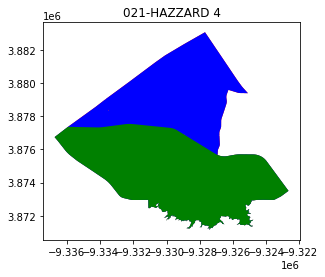

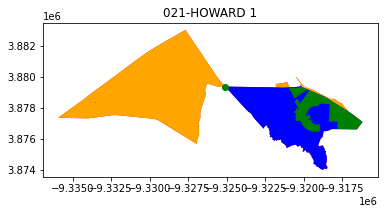

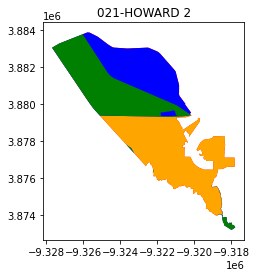

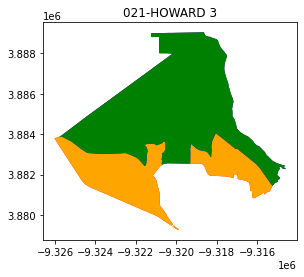

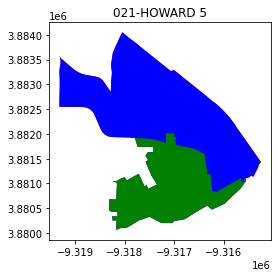

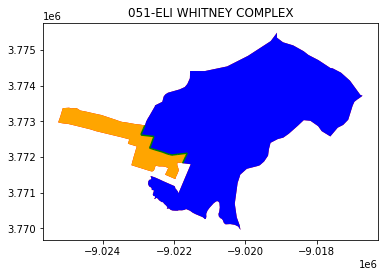

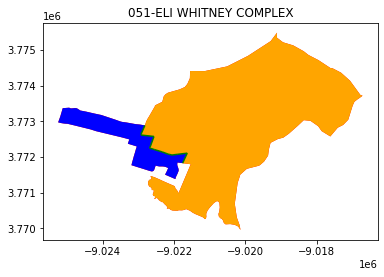

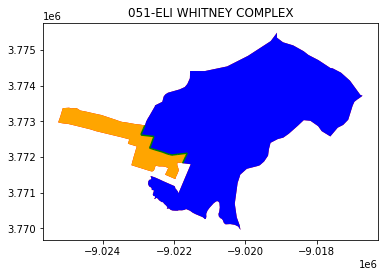

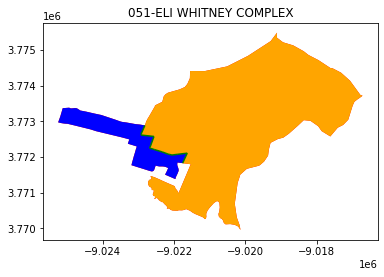

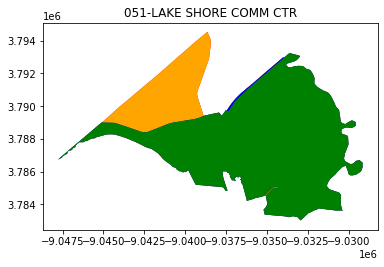

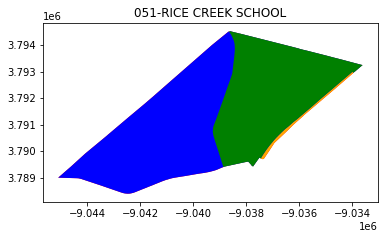

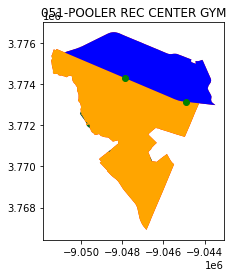

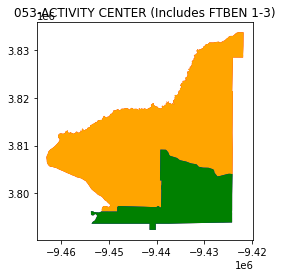

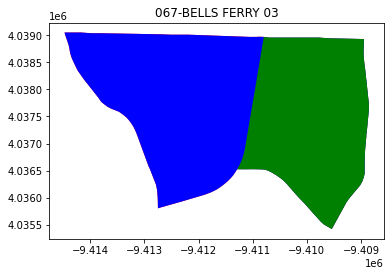

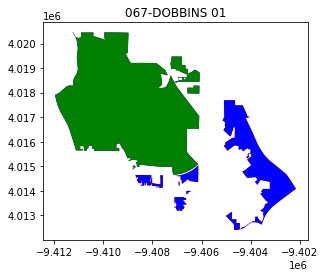

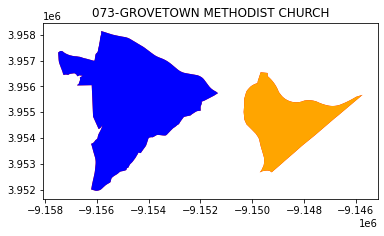

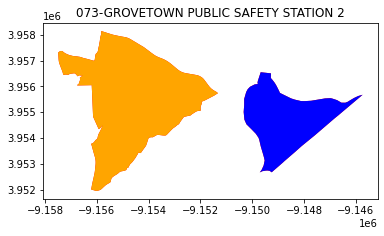

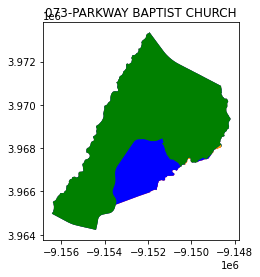

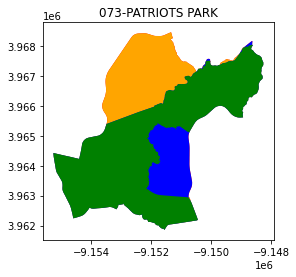

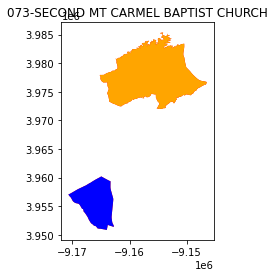

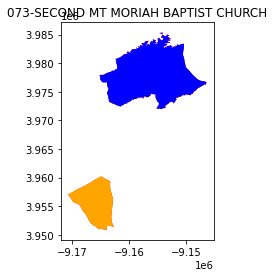

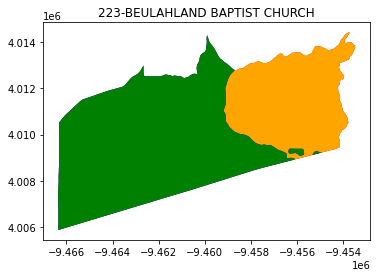

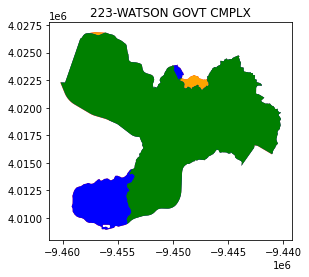

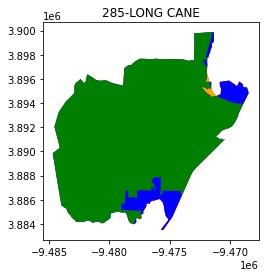

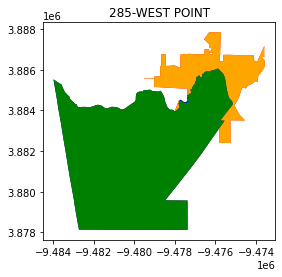

In [95]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    if (i!=825):
        diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
        intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)
        #print("Area is " + str(area))

        if (area > .5):
            count += 1
            name = source_geoms.iat[i,0]

            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)

In [92]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2650, 1)
1634 precincts w/ a difference of 0 km^2
969 precincts w/ a difference between 0 and .1 km^2
22 precincts w/ a difference between .1 and .5 km^2
6 precincts w/ a difference between .5 and 1 km^2
9 precincts w/ a difference between 1 and 2 km^2
6 precincts w/ a difference between 2 and 5 km^2
4 precincts w/ a difference greater than 5 km^2
